## GR5241 Statistical Machine Learning
### Data Analysis Project Milestone 1
### Name: Kangshuo Li  UNI: kl3259
![](GR5241_PROJ1_BG.png)

![](GR5241_PROJ1_2.png)

#### Setup

In [1]:
import torch
import torchvision
import pandas as pd
import numpy as np
import sklearn
import matplotlib
from matplotlib import pyplot as plt
import time
import os
import re
os.getcwd()

'/Users/kangshuoli/Documents/VScode_workspace/GR5241/Proj_milestone_1'

#### Data processing

In [2]:
# Data download and preprocessing
from torch.utils import data

DOWNLOAD_MNIST = False # If already download , set as False

train_data = torchvision.datasets.MNIST(
    root ="./mnist/",
    train = True , # this is training data
    # transform = torchvision.transforms.ToTensor(),
    download = DOWNLOAD_MNIST
)
test_data = torchvision.datasets.MNIST(root = "./mnist/", train = False)

# change the features to numpy
X_train = train_data.train_data.numpy()
X_test = test_data.test_data.numpy()

# change the labels to numpy
Y_train = train_data.train_labels.numpy()

Y_test = test_data.test_labels.numpy()

/Users/kangshuoli/miniforge3/envs/env_torch/lib/python3.9/site-packages/torchvision/datasets/mnist.py:64: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")
/Users/kangshuoli/miniforge3/envs/env_torch/lib/python3.9/site-packages/torchvision/datasets/mnist.py:69: UserWarning: test_data has been renamed data
  warnings.warn("test_data has been renamed data")
/Users/kangshuoli/miniforge3/envs/env_torch/lib/python3.9/site-packages/torchvision/datasets/mnist.py:54: UserWarning: train_labels has been renamed targets
  warnings.warn("train_labels has been renamed targets")
/Users/kangshuoli/miniforge3/envs/env_torch/lib/python3.9/site-packages/torchvision/datasets/mnist.py:59: UserWarning: test_labels has been renamed targets
  warnings.warn("test_labels has been renamed targets")


 ![](GR5241_PROJ_1_Q1.png)

##### (a)

(60000, 28, 28)
(60000,)


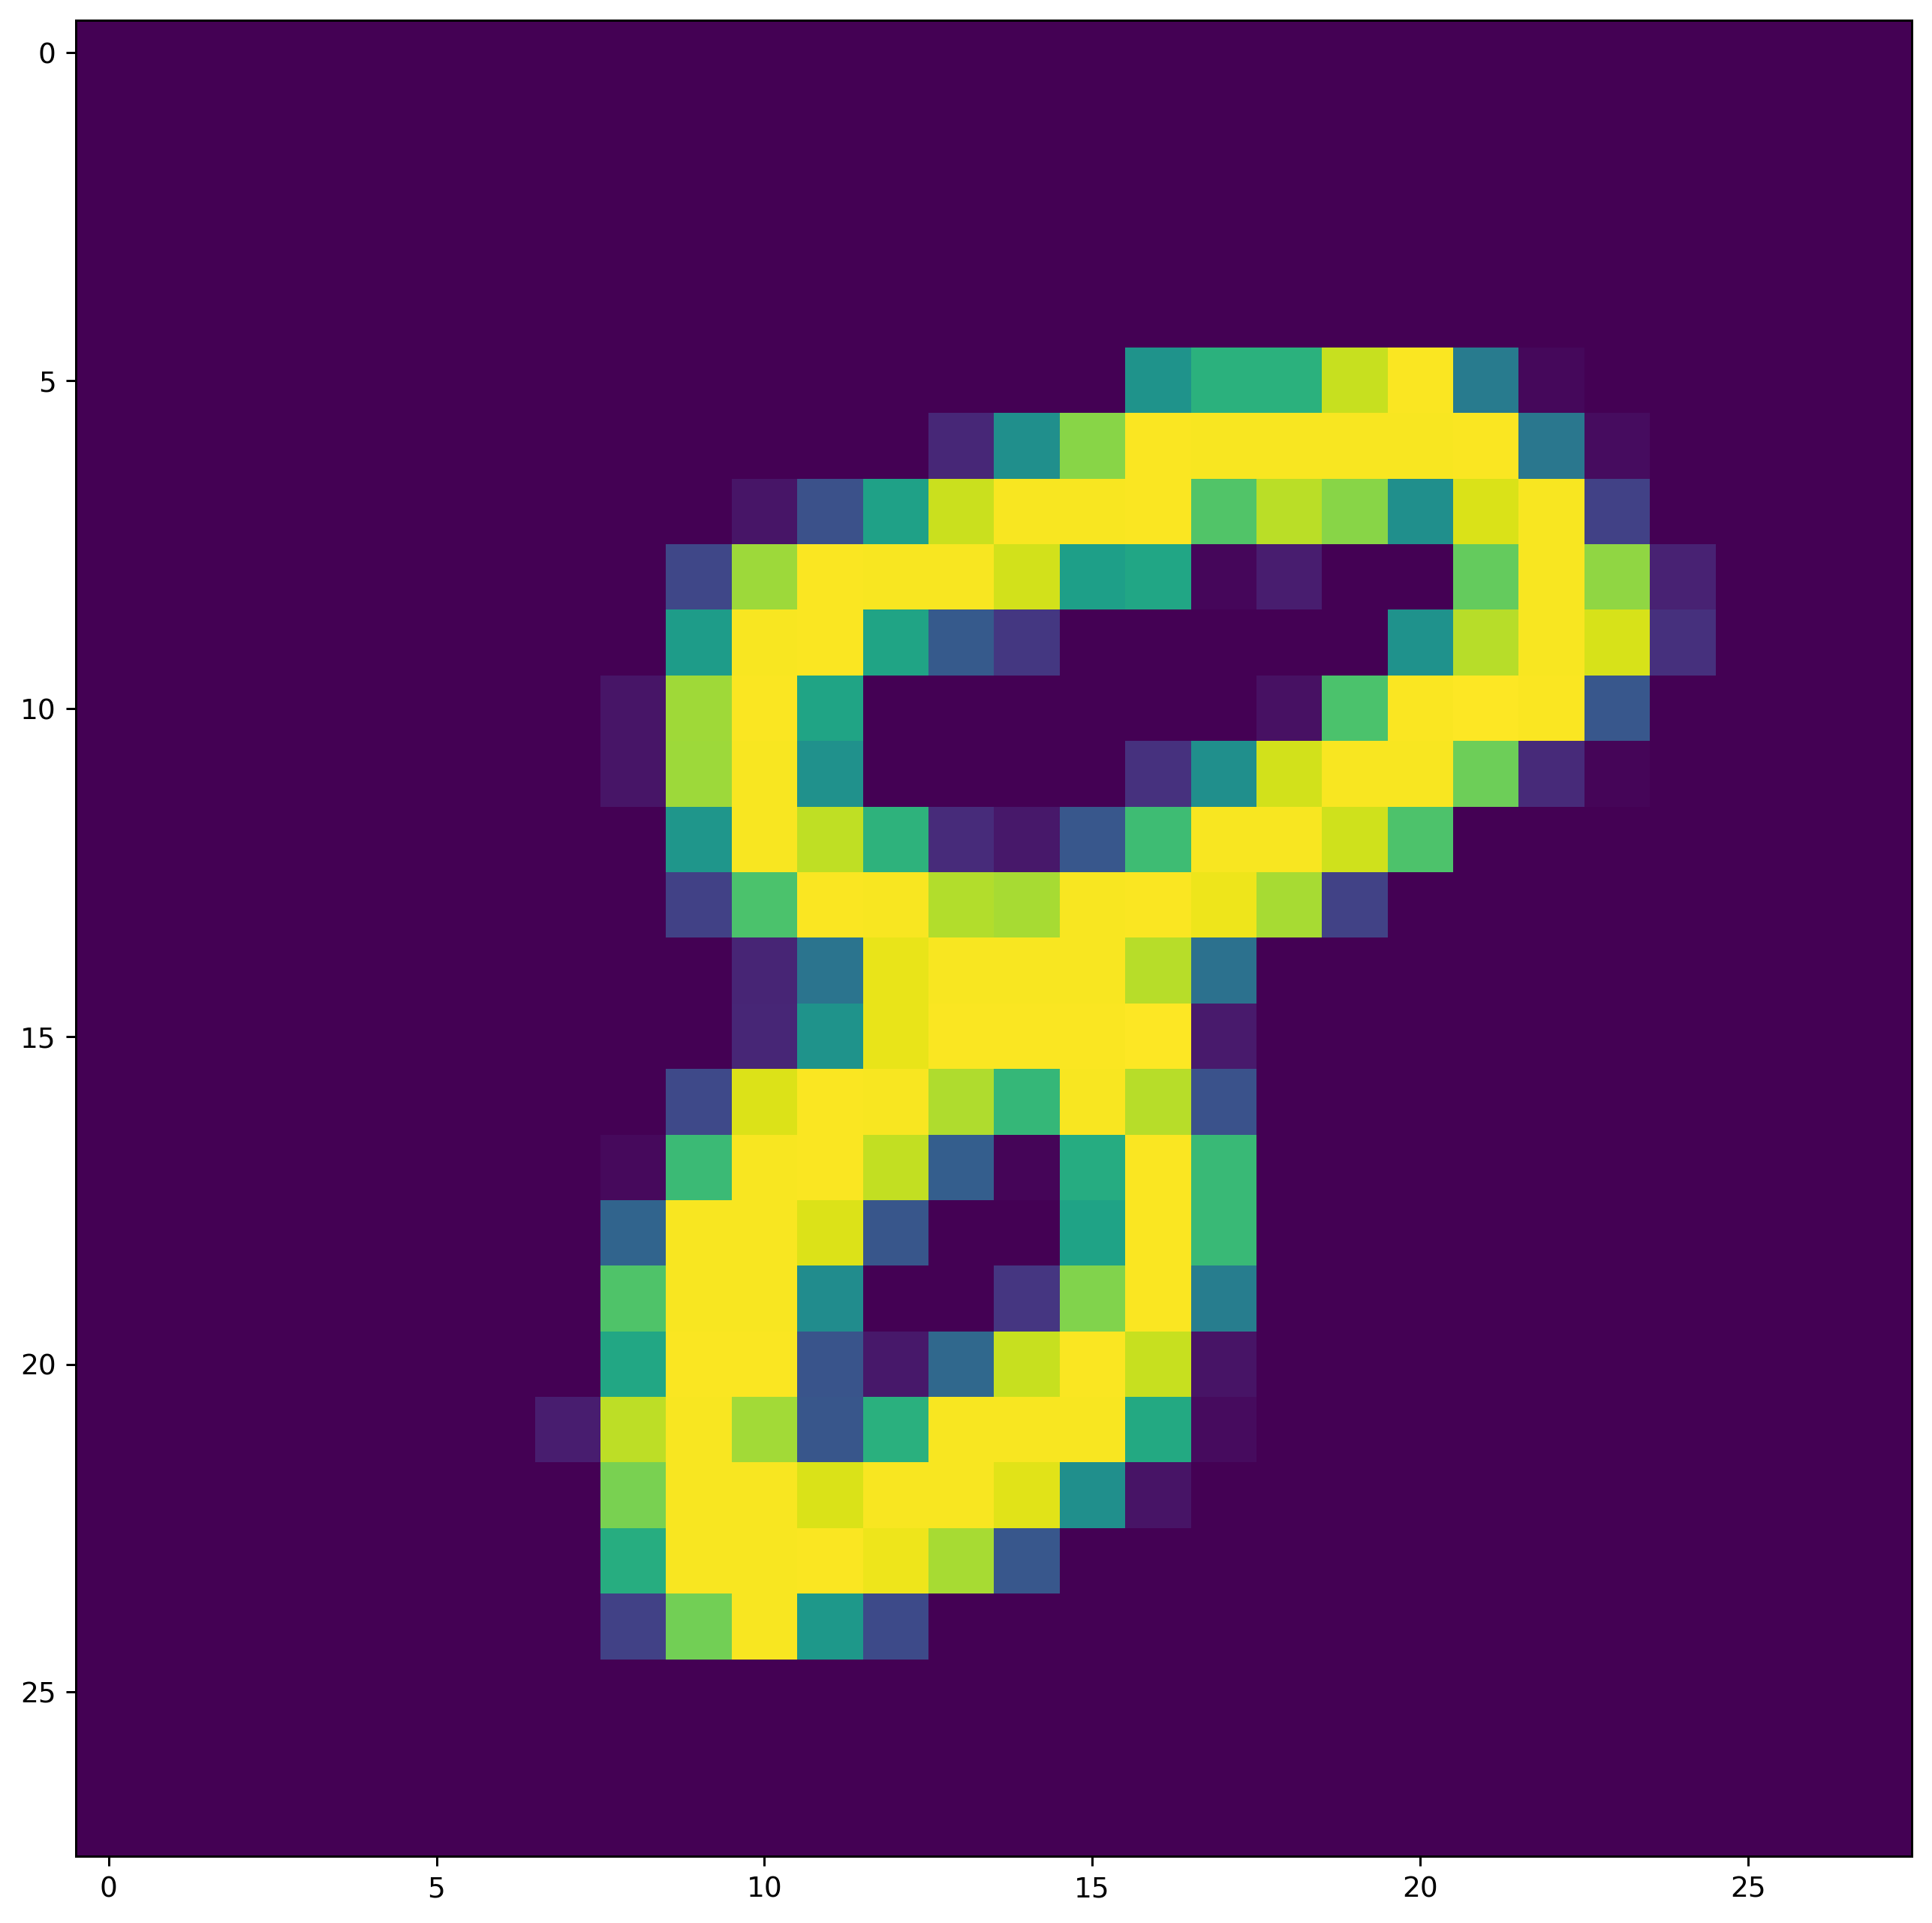

The corresponding label is: 8


In [3]:
print(X_train.shape) #(60000, 28, 28)
print(Y_train.shape) # (60000,)

random_index = np.random.randint(0, X_train.shape[0] - 1)
sample = X_train[random_index,:,:]
fig, ax = plt.subplots(1, 1, figsize = (12,12), dpi = 270)
ax.imshow(sample)
plt.show()
print(f'The corresponding label is: {Y_train[random_index]}')

According to the image and the label we sampled, the number shown from the image matches the label from Y_train.

##### (b)

In [4]:
print(f'The dimension of X_train: {X_train.shape}')
print(f'The dimension of X_test: {X_test.shape}')

# print(np.max(X_train)) # 255
# print(np.min(X_train)) # 0
# print(np.max(X_test)) # 255
# print(np.min(X_test)) # 0
X_train = (X_train - np.min(X_train)) / (np.max(X_train) - np.min(X_train))
X_test = (X_test - np.min(X_test)) / (np.max(X_test) - np.min(X_test))
assert np.max(X_train) == 1
assert np.min(X_train) == 0
assert np.max(X_test) == 1
assert np.min(X_test) == 0

The dimension of X_train: (60000, 28, 28)
The dimension of X_test: (10000, 28, 28)


The dimension of X_train is 60000 * 28 * 28, and the dimension of X_test is 10000 * 28 * 28. 

##### (c)

In [5]:
# Convert them into dataframe
Y_train_df = pd.DataFrame(Y_train).astype(object)
Y_test_df = pd.DataFrame(Y_test).astype(object)

# Use the get_dummies() method in pandas
Y_train_df = pd.get_dummies(Y_train_df)
Y_train_onehot = Y_train_df.values
print(f'Y_train after onehot encoding: \n {Y_train}')
print(f'After onehot encoding, the shape of Y_train is: {Y_train_df.values.shape}')
Y_test_df = pd.get_dummies(Y_test_df)
Y_test_onehot = Y_test_df.values
print(f'Y_test after onehot encoding: \n {Y_test}')
print(f'After onehot encoding, the shape of Y_test is: {Y_test_df.values.shape}')

Y_train after onehot encoding: 
 [5 0 4 ... 5 6 8]
After onehot encoding, the shape of Y_train is: (60000, 10)
Y_test after onehot encoding: 
 [7 2 1 ... 4 5 6]
After onehot encoding, the shape of Y_test is: (10000, 10)


The label in this question is 0-9, which is the meaning of the image. While integer encoding may have the natrual order like 1 + 2 = 3, one-hot encoding can aviod this unexpected order of value, which is beneficial for the classification. Besides that, one-hot encoding can enlarge the label dimension with dummy variables, this can provide same distances among each classes(e.g. (0,0,1), (0,1,0), (1,0,0) are 3 classes with same distance $\sqrt{2}$ with each other) that eliminate the ordinal effect. 

![](GR5241_PROJ1_Q2.png)

##### (a)

In [6]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.model_selection import KFold, GridSearchCV
from sklearn.metrics import accuracy_score, f1_score

# flatten the image
X_train_list = []
for i in np.arange(X_train.shape[0]):
    X_train_list.append(X_train[i,:,:].flatten(order = 'C'))
X_test_list = []
for i in np.arange(X_test.shape[0]):
    X_test_list.append(X_test[i,:,:].flatten(order = 'C'))
X_train_flattened = np.stack(X_train_list)
X_test_flattened = np.stack(X_test_list)

In [7]:
params_knn = {
    'n_neighbors': [2, 5, 10], 
    'weights': ["uniform", "distance"], 
    'p': [2], 
    'n_jobs': [-1]
}

gs_knn = GridSearchCV(
    estimator = KNeighborsClassifier(), 
    param_grid = params_knn, 
    cv = 5, 
    scoring = 'accuracy', 
    refit = True, 
    n_jobs = -1, 
    verbose = 0
)
gs_knn.fit(X = X_train_flattened, y = Y_train_onehot)
print(f'The best training score of KNN is: {gs_knn.best_score_:0.4f}, the parameters used are: {gs_knn.best_params_}')
print(f'The prediction score of KNN is: {accuracy_score(Y_test_onehot, gs_knn.best_estimator_.predict(X_test_flattened)):0.4f}')

The best training score of KNN is: 0.9694, the parameters used are: {'n_jobs': -1, 'n_neighbors': 2, 'p': 2, 'weights': 'distance'}
The prediction score of KNN is: 0.9691


In [15]:
params_ada = {
    'base_estimator': [DecisionTreeClassifier(max_depth = 8)],
    'n_estimators': [1000], 
    'learning_rate': [0.2], 
    'algorithm': ['SAMME.R'], 
    'random_state': [42]
}

gs_ada = GridSearchCV(
    estimator = AdaBoostClassifier(), 
    param_grid = params_ada, 
    cv = 5, 
    scoring = 'accuracy', 
    refit = True, 
    n_jobs = -1, 
    verbose = 2
)


gs_ada.fit(X = X_train_flattened, y = Y_train)
print(f'The best training score of AdaBoost is: {gs_ada.best_score_:0.4f}, the parameters used are: {gs_ada.best_params_}')
print(f'The prediction score of AdaBoost is: {accuracy_score(Y_test, gs_ada.best_estimator_.predict(X_test_flattened)):0.4f}')

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV] END algorithm=SAMME.R, base_estimator=DecisionTreeClassifier(max_depth=8), learning_rate=0.2, n_estimators=1000, random_state=42; total time=66.7min
[CV] END algorithm=SAMME.R, base_estimator=DecisionTreeClassifier(max_depth=8), learning_rate=0.2, n_estimators=1000, random_state=42; total time=66.7min
[CV] END algorithm=SAMME.R, base_estimator=DecisionTreeClassifier(max_depth=8), learning_rate=0.2, n_estimators=1000, random_state=42; total time=66.9min
[CV] END algorithm=SAMME.R, base_estimator=DecisionTreeClassifier(max_depth=8), learning_rate=0.2, n_estimators=1000, random_state=42; total time=66.9min
[CV] END algorithm=SAMME.R, base_estimator=DecisionTreeClassifier(max_depth=8), learning_rate=0.2, n_estimators=1000, random_state=42; total time=67.0min
The best training score of AdaBoost is: 0.9563, the parameters used are: {'algorithm': 'SAMME.R', 'base_estimator': DecisionTreeClassifier(max_depth=8), 'learning_rate': 0

In [22]:
params_dectree = {
    'max_depth': [None, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20], 
    'min_samples_split': [None, 2, 3, 4, 5, 6, 7, 8, 9, 10], 
    'max_features': ["auto", "log2", "sqrt"], 
    'random_state': [42]
}

gs_dectree = GridSearchCV(
    estimator = DecisionTreeClassifier(), 
    param_grid = params_dectree, 
    cv = 5, 
    scoring = 'accuracy', 
    refit = True, 
    n_jobs = -1, 
    verbose = 2
)


gs_dectree.fit(X = X_train_flattened, y = Y_train)
print(f'The best training score of C4.5 is: {gs_dectree.best_score_:0.4f}, the parameters used are: {gs_dectree.best_params_}')
print(f'The prediction score of C4.5 is: {accuracy_score(Y_test, gs_dectree.best_estimator_.predict(X_test_flattened)):0.4f}')

Fitting 5 folds for each of 360 candidates, totalling 1800 fits
[CV] END max_depth=None, max_features=auto, min_samples_split=None, random_state=42; total time=   0.2s
[CV] END max_depth=None, max_features=auto, min_samples_split=None, random_state=42; total time=   0.2s
[CV] END max_depth=None, max_features=auto, min_samples_split=None, random_state=42; total time=   0.2s
[CV] END max_depth=None, max_features=auto, min_samples_split=None, random_state=42; total time=   0.2s
[CV] END max_depth=None, max_features=auto, min_samples_split=None, random_state=42; total time=   0.2s
[CV] END max_depth=None, max_features=auto, min_samples_split=2, random_state=42; total time=   0.6s
[CV] END max_depth=None, max_features=auto, min_samples_split=2, random_state=42; total time=   0.6s
[CV] END max_depth=None, max_features=auto, min_samples_split=2, random_state=42; total time=   0.6s
[CV] END max_depth=None, max_features=auto, min_samples_split=2, random_state=42; total time=   0.6s
[CV] END max

/Users/kangshuoli/miniforge3/envs/env_torch/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
180 fits failed out of a total of 1800.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
180 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/kangshuoli/miniforge3/envs/env_torch/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/kangshuoli/miniforge3/envs/env_torch/lib/python3.9/site-packages/sklearn/tree/_classes.py", line 937, in fit
    super().fit(
  File "/Users/kangshuoli/miniforge3/envs/env_torch/lib/python3.9/site-packages/sklearn/tree/_classes.py", 

The best training score of C4.5 is: 0.8294, the parameters used are: {'max_depth': 14, 'max_features': 'auto', 'min_samples_split': 5, 'random_state': 42}
The prediction score of C4.5 is: 0.8365


##### (b)